# Overview

The data has been split into two groups:

- **Training set (`train.csv`)**  
- **Test set (`test.csv`)**

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the **“ground truth”**) for each passenger. Your model will be based on **features** like passengers’ gender and class. You can also use **feature engineering** to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we **do not provide the ground truth** for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include `gender_submission.csv`, a set of predictions that assume **all and only female passengers survive**, as an example of what a submission file should look like.

---

# Data Dictionary

| Variable  | Definition                 | Key                                      |
|-----------|---------------------------|------------------------------------------|
| survival  | Survival                  | 0 = No, 1 = Yes                          |
| pclass    | Ticket class              | 1 = 1st, 2 = 2nd, 3 = 3rd               |
| sex       | Sex                       |                                          |
| age       | Age in years              |                                          |
| sibsp     | # of siblings / spouses   |                                          |
| parch     | # of parents / children   |                                          |
| ticket    | Ticket number             |                                          |
| fare      | Passenger fare            |                                          |
| cabin     | Cabin number              |                                          |
| embarked  | Port of Embarkation       | C = Cherbourg, Q = Queenstown, S = Southampton |

---

# Variable Notes

- **pclass**: A proxy for socio-economic status (SES)  
  - 1st = Upper  
  - 2nd = Middle  
  - 3rd = Lower  

- **age**: Age is fractional if less than 1. If the age is estimated, it is in the form `xx.5`.

- **sibsp**: Family relations are defined as:  
  - Sibling = brother, sister, stepbrother, stepsister  
  - Spouse = husband, wife (mistresses and fiancés were ignored)

- **parch**: Family relations are defined as:  
  - Parent = mother, father  
  - Child = daughter, son, stepdaughter, stepson  
  - Some children traveled only with a nanny, therefore `parch=0` for them.


In [ ]:
import pandas as pd
import numpy as np
import hvplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import tensorflow as tf
from sklearn.ensemble import VotingClassifier

In [205]:
train_df = pd.read_csv("./data/train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

In [206]:
train_df.shape

(891, 12)

In [207]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Age have some missing values, could be filled with mean
- Cabin have a lot of missing values and a lot of number categories, should be dropped
- PassengerID and Name, unique value -> should be dropped
- check counts for all object data, to decide how to encode

In [208]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [209]:
train_df.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'], inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18356\115096897.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived',data=train_df, palette='pastel')


<Axes: xlabel='Survived', ylabel='count'>

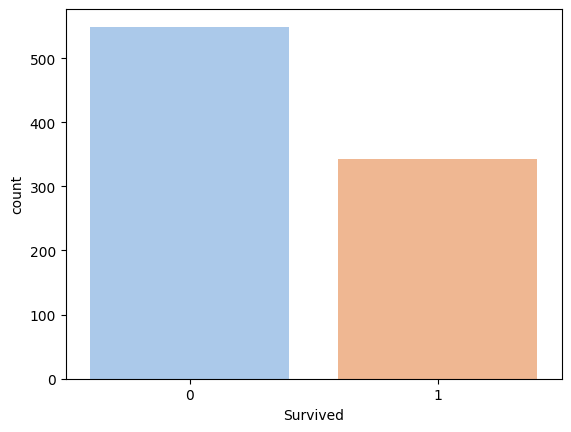

In [73]:
train_df['Survived'].value_counts()
sns.countplot(x='Survived',data=train_df, palette='pastel')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18356\298890889.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Pclass',data=train_df, palette='pastel')


<Axes: xlabel='Pclass', ylabel='count'>

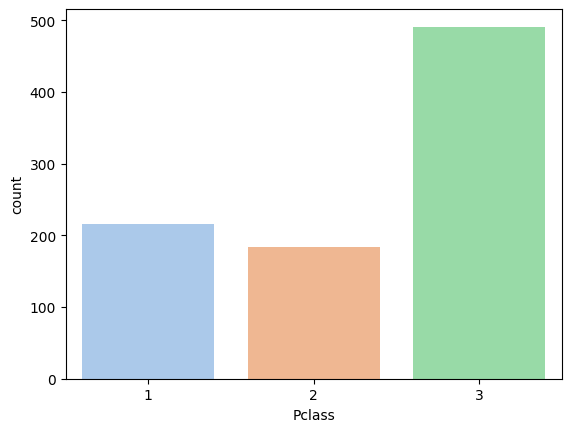

In [74]:
train_df['Pclass'].value_counts()
sns.countplot(x='Pclass',data=train_df, palette='pastel')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18356\1140878528.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex',data=train_df, palette='pastel')


<Axes: xlabel='Sex', ylabel='count'>

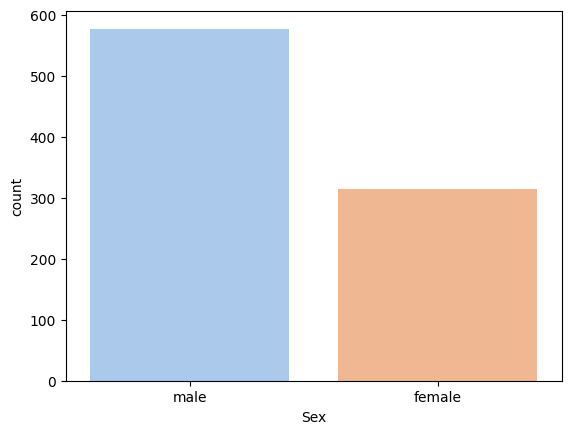

In [75]:
train_df['Sex'].value_counts()
sns.countplot(x='Sex',data=train_df, palette='pastel')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18356\45196773.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SibSp',data=train_df, palette='pastel')


<Axes: xlabel='SibSp', ylabel='count'>

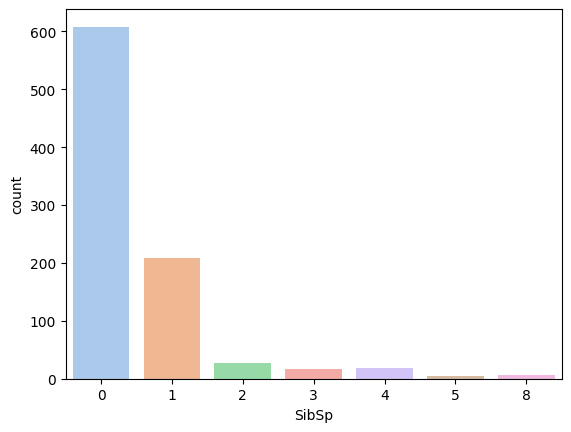

In [76]:
train_df['SibSp'].value_counts()
sns.countplot(x='SibSp',data=train_df, palette='pastel')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18356\1499838932.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Parch',data=train_df, palette='pastel')


<Axes: xlabel='Parch', ylabel='count'>

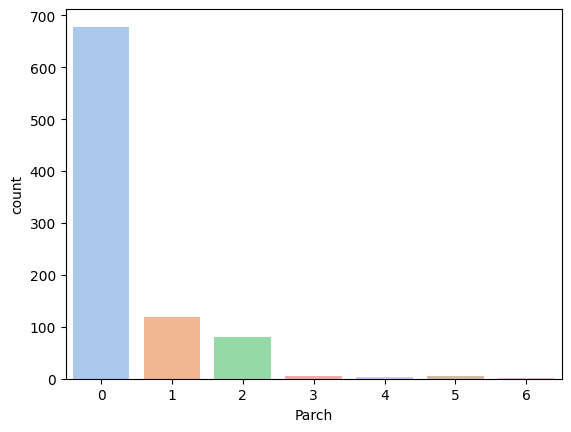

In [77]:
train_df['Parch'].value_counts()
sns.countplot(x='Parch',data=train_df, palette='pastel')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18356\4237975731.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Embarked',data=train_df, palette='pastel')


<Axes: xlabel='Embarked', ylabel='count'>

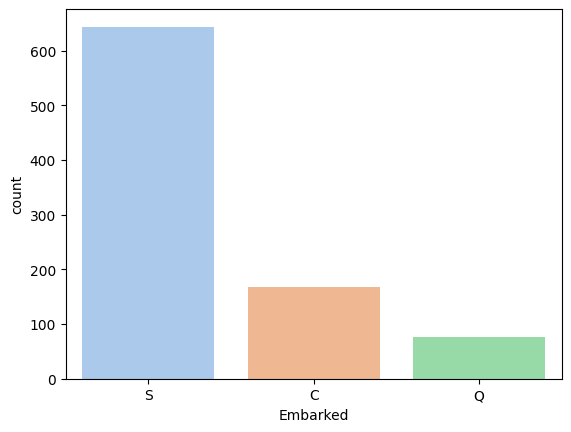

In [78]:
train_df['Embarked'].value_counts()
sns.countplot(x='Embarked',data=train_df, palette='pastel')

In [51]:
plot_me = train_df.groupby(["Sex", "Survived"])[["Survived"]].count().rename(columns={"Survived":"count"})
plot_me.hvplot.bar(stacked=True,color=["maroon","teal"],line_width=3,
                   line_color="black",height=350,width=500)

:Bars   [Sex,Survived]   (count)

In [54]:
plot_me = train_df.groupby(["Pclass", "Survived"])[["Survived"]].count().rename(columns={"Survived":"count"})
plot_me.hvplot.bar(stacked=True,color=["maroon","teal"],line_width=3,
                    line_color="black",height=350,width=500)

:Bars   [Pclass,Survived]   (count)

In [57]:
plot_me = train_df.groupby(["SibSp", "Survived"])[["Survived"]].count().rename(columns={"Survived":"count"})
plot_me.hvplot.bar(stacked=True,color=["maroon","teal"],line_width=3,
                    line_color="black",height=350,width=700)

:Bars   [SibSp,Survived]   (count)

In [58]:
plot_me = train_df.groupby(["Parch", "Survived"])[["Survived"]].count().rename(columns={"Survived":"count"})
plot_me.hvplot.bar(stacked=True,color=["maroon","teal"],line_width=3,
                    line_color="black",height=350,width=700)

:Bars   [Parch,Survived]   (count)

In [53]:
plot_me = train_df.groupby(["Embarked", "Survived"])[["Survived"]].count().rename(columns={"Survived":"count"})
plot_me.hvplot.bar(stacked=True,color=["maroon","teal"],line_width=3,
                    line_color="black",height=350,width=500)

:Bars   [Embarked,Survived]   (count)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18356\3825076108.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=train_df, x="Survived", y="Age", kind="box", palette=palette)


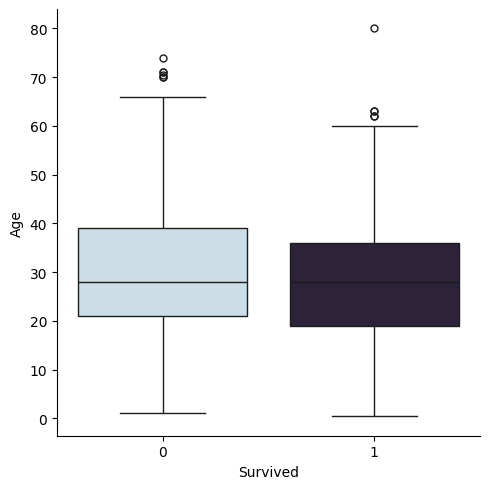

In [68]:
palette = sns.color_palette("ch:s=.25,rot=-.25", n_colors=2)
sns.catplot(data=train_df, x="Survived", y="Age", kind="box", palette=palette)

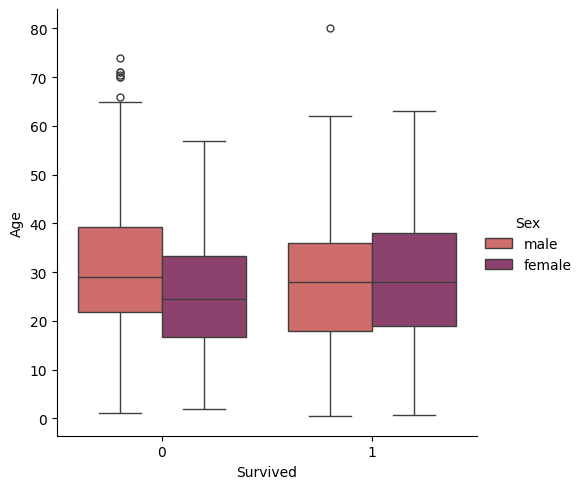

In [66]:
palette = sns.color_palette("flare", n_colors=2)
sns.catplot(data=train_df, x="Survived", y="Age", hue="Sex", kind="box", palette=palette)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18356\481544930.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=train_df, x="Survived", y="Fare", kind="box", palette=palette)


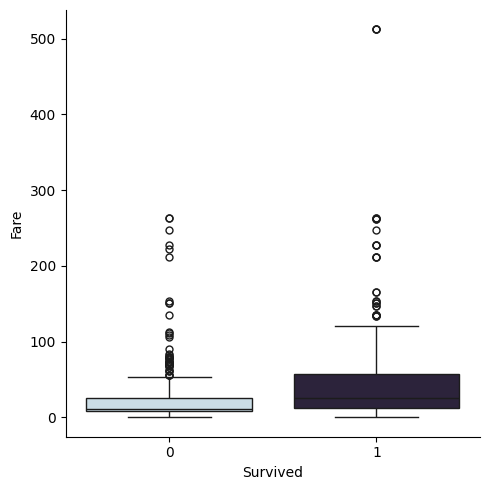

In [89]:
palette = sns.color_palette("ch:s=.25,rot=-.25", n_colors=2)
sns.catplot(data=train_df, x="Survived", y="Fare", kind="box", palette=palette)

### Comments On EDA
- Most of the passengers on titanic didn't survive
- Females have much higher surviving rates than Males
- First Class passengers have higher surviving rate, as for the 3rd class passengers most of them didn't survived
- I can't detect a significant pattern in SibSp, Parch, and Embarked
- The distribution of Survived people tends to be towards younger people with no big difference in distribution between survived and not
- Older Females and younger Males Survived
- younger Females and older Males didn't Survive

## Feature Engineering

In [210]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [220]:
age_by_pclass_sex = train_df.groupby(['Sex', 'Pclass'])['Age'].median()

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(train_df['Age'].median()))

Median age of Pclass 1 females: 35.0
Median age of Pclass 1 males: 40.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 30.0
Median age of Pclass 3 females: 21.5
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [224]:
# Filling the missing values in Age with the medians of Sex and Pclass groups
train_df['Age'] = train_df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median())).reset_index(level=[0,1], drop=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [226]:
# Create New Feature
train_df["is_child"] = train_df["Age"].apply(lambda x: 1 if x<18 else 0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
 8   is_child  891 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [230]:
# Create New Feature
train_df["family"] = train_df["SibSp"] + train_df["Parch"] + 1 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
 8   is_child  891 non-null    int64  
 9   family    891 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 69.7+ KB


### Encode All Categorical Features to check for Correlation

In [231]:
train_df["Embarked"] = train_df["Embarked"].map({'S': 1, 'B': 2, 'C': 3})
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    float64
 8   is_child  891 non-null    int64  
 9   family    891 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 69.7+ KB


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18356\2404480807.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)


In [232]:
train_df = pd.get_dummies(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked    891 non-null    float64
 7   is_child    891 non-null    int64  
 8   family      891 non-null    int64  
 9   Sex_female  891 non-null    bool   
 10  Sex_male    891 non-null    bool   
dtypes: bool(2), float64(3), int64(6)
memory usage: 64.5 KB


In [233]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_child,family,Sex_female,Sex_male
Survived,1.000000,-0.338481,-0.059579,-0.035322,0.081629,0.257307,0.168240,0.122239,0.016639,0.543351,-0.543351
Pclass,-0.338481,1.000000,-0.413583,0.083081,0.018443,-0.549500,-0.243292,0.125620,0.065997,-0.131900,0.131900
Age,-0.059579,-0.413583,1.000000,-0.249854,-0.175526,0.122692,0.041114,-0.575265,-0.258456,-0.102706,0.102706
SibSp,-0.035322,0.083081,-0.249854,1.000000,0.414838,0.159651,-0.059528,0.324068,0.890712,0.114631,-0.114631
Parch,0.081629,0.018443,-0.175526,0.414838,1.000000,0.216225,-0.011069,0.317670,0.783111,0.245489,-0.245489
Fare,0.257307,-0.549500,0.122692,0.159651,0.216225,1.000000,0.269335,-0.007546,0.217138,0.182333,-0.182333
Embarked,0.168240,-0.243292,0.041114,-0.059528,-0.011069,0.269335,1.000000,0.023225,-0.046215,0.082853,-0.082853
is_child,0.122239,0.125620,-0.575265,0.324068,0.317670,-0.007546,0.023225,1.000000,0.380192,0.107150,-0.107150
family,0.016639,0.065997,-0.258456,0.890712,0.783111,0.217138,-0.046215,0.380192,1.000000,0.200988,-0.200988
Sex_female,0.543351,-0.131900,-0.102706,0.114631,0.245489,0.182333,0.082853,0.107150,0.200988,1.000000,-1.000000


- Gender has the highest correlation
- Fare and Pclass have better correlation than the rest
- Gender, Fare, and Pclass will be used in the model

In [234]:
df = train_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked    891 non-null    float64
 7   is_child    891 non-null    int64  
 8   family      891 non-null    int64  
 9   Sex_female  891 non-null    bool   
 10  Sex_male    891 non-null    bool   
dtypes: bool(2), float64(3), int64(6)
memory usage: 64.5 KB


## Model

In [235]:
# Data Split

X = df.drop(columns="Survived")
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (712, 10)
X_test shape: (179, 10)
y_train shape: (712,)
y_test shape: (179,)


In [250]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'is_child', 'family', 'Sex_female', 'Sex_male']

In [236]:
# Data Normalization
scaler = StandardScaler()
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

In [256]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    # Classification metric
    accuracy = metrics.accuracy_score(y_true, y_pred)

    # Print results
    print('Accuracy: ', round(accuracy, 4))
    print('Explained Variance: ', round(explained_variance, 4))
    print('Mean Squared Log Error: ', round(mean_squared_log_error, 4))
    print('R2 Score: ', round(r2, 4))
    print('Mean Absolute Error (MAE): ', round(mean_absolute_error, 4))
    print('Mean Squared Error (MSE): ', round(mse, 4))
    print('Median Absolute Error: ', round(median_absolute_error, 4))

Regression Report: 
Accuracy:  0.8156
Explained Variance:  0.2461
Mean Squared Log Error:  0.0886
R2 Score:  0.2398
Mean Absolute Error (MAE):  0.1844
Mean Squared Error (MSE):  0.1844
Median Absolute Error:  0.0
      Feature  Importance
8  Sex_female    1.351052
9    Sex_male    1.338870
0      Pclass    0.935234
6    is_child    0.902079
1         Age    0.269069
5    Embarked    0.186722
2       SibSp    0.186606
7      family    0.185293
4        Fare    0.157066
3       Parch    0.010870


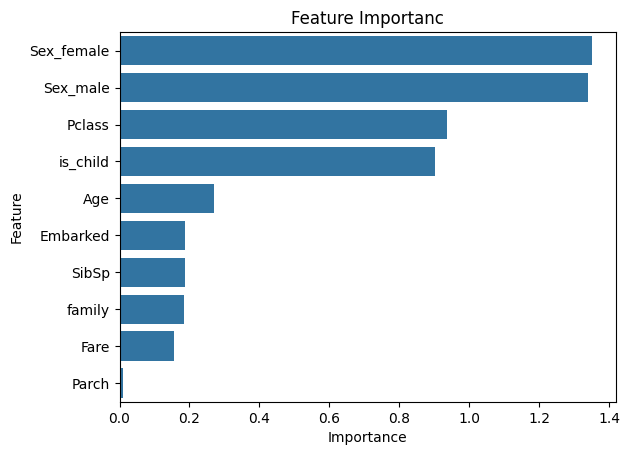

In [279]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print("Regression Report: ")
regression_results(y_true=y_test, y_pred=y_pred)

importances = abs(log_reg.coef_[0])
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": abs(importances)})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print(feature_importance_df)

sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importanc")
plt.show()


In [280]:
y_pred = log_reg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cnf_matrix)


print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1 Score:', metrics.f1_score(y_test, y_pred))

Confusion matrix
[[92 13]
 [20 54]]
Precision: 0.8059701492537313
Recall: 0.7297297297297297
F1 Score: 0.7659574468085106


In [239]:
# Nonlinear SVM
svm_clf = SVC(kernel="rbf", gamma='scale', C=1)
svm_clf.fit(X_train, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [264]:
y_pred = svm_clf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cnf_matrix)

print("Regression Report: ")
regression_results(y_true=y_test, y_pred=y_pred)

print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1 Score:', metrics.f1_score(y_test, y_pred))

Confusion matrix
[[92 13]
 [20 54]]
Regression Report: 
Accuracy:  0.8156
Explained Variance:  0.2461
Mean Squared Log Error:  0.0886
R2 Score:  0.2398
Mean Absolute Error (MAE):  0.1844
Mean Squared Error (MSE):  0.1844
Median Absolute Error:  0.0
Precision: 0.8059701492537313
Recall: 0.7297297297297297
F1 Score: 0.7659574468085106


In [265]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [267]:
y_pred = rnd_clf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cnf_matrix)

print("Regression Report: ")
regression_results(y_true=y_test, y_pred=y_pred)

print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1 Score:', metrics.f1_score(y_test, y_pred))

Confusion matrix
[[90 15]
 [16 58]]
Regression Report: 
Accuracy:  0.8268
Explained Variance:  0.286
Mean Squared Log Error:  0.0832
R2 Score:  0.2858
Mean Absolute Error (MAE):  0.1732
Mean Squared Error (MSE):  0.1732
Median Absolute Error:  0.0
Precision: 0.7945205479452054
Recall: 0.7837837837837838
F1 Score: 0.7891156462585034


In [274]:
model = tf.keras.Sequential([
                  tf.keras.layers.Dense(128, activation="relu"),
                  tf.keras.layers.Dense(128, activation="relu"),
                  tf.keras.layers.Dense(1, activation="sigmoid")
 ])

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [275]:
# Fit the model
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), verbose=1)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6868 - loss: 0.5899 - val_accuracy: 0.7821 - val_loss: 0.4959


In [276]:
model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7821 - loss: 0.4959 


[0.49592649936676025, 0.7821229100227356]

In [277]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)


Best Hyperparameters: {'C': 0.1, 'solver': 'saga'}
Best Cross-validation Accuracy: 0.8019304639022948


c:\Users\Lenovo\Desktop\important code\projects-portfolio\env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [278]:
model1 = LogisticRegression()
model2 = RandomForestClassifier()

ensemble_model = VotingClassifier(estimators=[('lr', model1), ('rf', model2)], voting='hard')
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
print("Ensemble Accuracy:", metrics.accuracy_score(y_test, y_pred_ensemble))


Ensemble Accuracy: 0.8156424581005587
